In [ ]:
from google.colab import files # для работы с файлами
import numpy as np # для работы с данными
import pandas as pd #для работы с таблицами
import matplotlib.pyplot as plt #для вывода графиков
import os #для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # для работы с категориальными данными
from tensorflow.keras.models import Sequential #полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, Flatten, BatchNormalization,Embedding, Activation
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # метод кодирования текстовых лейблов
from sklearn.model_selection import train_test_split #для разделения выборки на тестовую и обучающую
from google.colab import drive #для работы с Google Drive



In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -R '/content/texts' # Проверяем наличие папки texts. Если есть, удаляем ее

In [ ]:
#создаем папку и распаковываем в нее базу писателей

!unzip -q '/content/drive/MyDrive/Тексты писателей.zip' -d '/content/texts'

In [ ]:
def readText(fileName): #объявляем функцию для чтения файла, на вход ей передаем путь к файлу
  f = open(fileName, 'r') #задаем открытие нужного файла в режиме для чтения
  text = f.read() #читаем текст
  text = text.replace("\n"," ") # меняем перенос строки на пробел

  return text

className = ['О. Генри','Стругацкие','Булгаков','Саймак','Рэй Брэдберри','Фрай'] #объявляем интересующие нас классы
nClasses = len(className)  #считаем количество классов


In [ ]:
# работа  с обучающими текстами
trainText = []
testText = []
path = '/content/texts/Тексты писателей/'
for i in className: #Проходим по каждому классу
  for j in os.listdir(path): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText(path + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText(path + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print() 

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку



In [ ]:
# Преобразование текстовых данных в числовые и векторные для обучения нейронной сети

maxWordsCount = 20000 #определяем максимальное число слов/индексов

#создаем токенайзер
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ',char_level=False,oov_token='unknown') 
tokenizer.fit_on_texts(trainText) #создаем словарь частотности на основе обучающего текста

In [ ]:
# преобразовываем исходные тексты в последовательность индексов(согласно словарю частотности)
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

In [ ]:
#создание обучающей и проверочной выборки
#пишем функцию для "раскусывания" последовательности индексов на небольшие вектора

def getSetFromIndexes(wordIndexes, xLen, step): #на вход функция принимает последовательность индексов, размер окна, шаг
  xSample = [] #объявляем переменную для векторов
  wordsLen = len(wordIndexes) #считаем количество слов
  index = 0 # задаем начальный индекс

  while (index +xLen <=wordsLen): # пока индекс + размер окна меньше количества слов
    xSample.append(wordIndexes[index:index+xLen]) # добавляем в переменную вектор длиной размер окна("откусываем" векторы длиной xLen)
    index += step #смещаемся на длину шага

  return xSample # функция возвращает список векторов

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

In [ ]:
# Задаем базовые параметры

xLen = 5000 #размер окна
step = 300 #шаг


In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку, 
  xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

In [ ]:
l = np.array(xTest6Classes01)
np.save('xTestPredictBoW', l)
np.save('xTestPredictEmbedding', x2)

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/10
46/46 [==============================] - 4s 70ms/step - loss: 0.0728 - accuracy: 0.9774 - val_loss: 0.3899 - val_accuracy: 0.8312
Epoch 2/10
46/46 [==============================] - 3s 65ms/step - loss: 8.1807e-04 - accuracy: 1.0000 - val_loss: 0.2667 - val_accuracy: 0.9228
Epoch 3/10
46/46 [==============================] - 3s 64ms/step - loss: 4.5921e-04 - accuracy: 1.0000 - val_loss: 0.2383 - val_accuracy: 0.9433
Epoch 4/10
46/46 [==============================] - 3s 65ms/step - loss: 3.1193e-04 - accuracy: 1.0000 - val_loss: 0.2230 - val_accuracy: 0.9558
Epoch 5/10
46/46 [==============================] - 3s 64ms/step - loss: 2.3595e-04 - accuracy: 1.0000 - val_loss: 0.2135 - val_accuracy: 0.9623
Epoch 6/10
46/46 [==============================] - 3s 65ms/step - loss: 1.7377e-04 - accuracy: 1.0000 - val_loss: 0.2077 - val_accuracy: 0.9651
Epoch 7/10
46/46 [==============================] - 3s 65ms/step - loss: 1.5305e-04 - accuracy: 1.0000 - val_loss: 0.2030 - val_accura

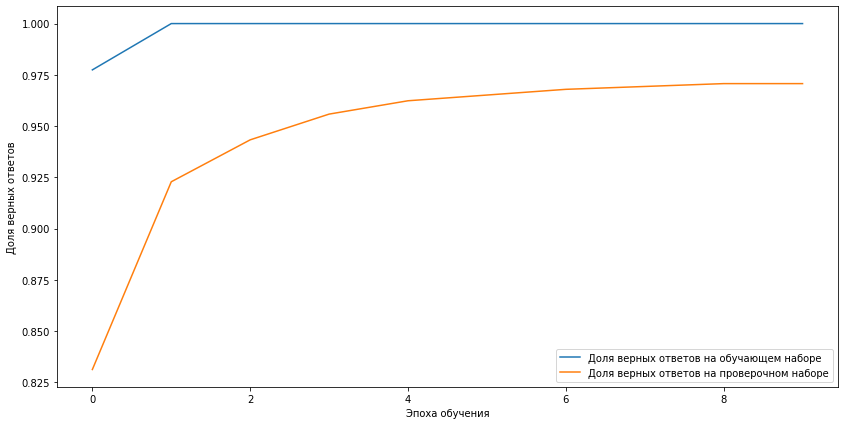

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 98% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   99% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     99% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Рэй Брэдберри100% сеть отнесла к классу Рэй БрэдберриЭто ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       91% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 97%

